In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler

def rossler(xyz, a=0.2, b=0.2, c=5.7):
    x, y, z = xyz
    return np.array([-y - z, x + a * y, b + z * (x - c)], dtype=np.float64)

def simulate_rossler_euler(dt=0.01, num_steps=5000, y0=(1.0, 1.0, 0.0)):
    y = np.zeros((num_steps + 1, 3), dtype=np.float64)
    y[0] = np.array(y0, dtype=np.float64)
    for i in range(num_steps):
        y[i + 1] = y[i] + dt * rossler(y[i])
    return y

def delay_embed_scalar(X, tau, dim):
    new = np.zeros((len(X) - tau * dim, dim), dtype=np.float64)
    for i in range(dim):
        new[:, i] = X[dim * tau - (i + 1) * tau: -(1 + i) * tau]
    return new

dt = 0.01
num_steps = 5000
tau = 30
dim_delay = 5
split_ratio = 0.7

Y = simulate_rossler_euler(dt=dt, num_steps=num_steps, y0=(1.0, 1.0, 0.0))
transformer = MaxAbsScaler().fit(Y)
Y_scaled = transformer.transform(Y)

x_s = Y_scaled[:, 0]
z_s = Y_scaled[:, 2]

Dx = delay_embed_scalar(x_s, tau=tau, dim=dim_delay)
Dz = delay_embed_scalar(z_s, tau=tau, dim=dim_delay)

L = min(len(Dx), len(Dz))
split = int(split_ratio * L)

Dx_tr, Dx_va = Dx[:split], Dx[split:]
Dz_tr, Dz_va = Dz[:split], Dz[split:]


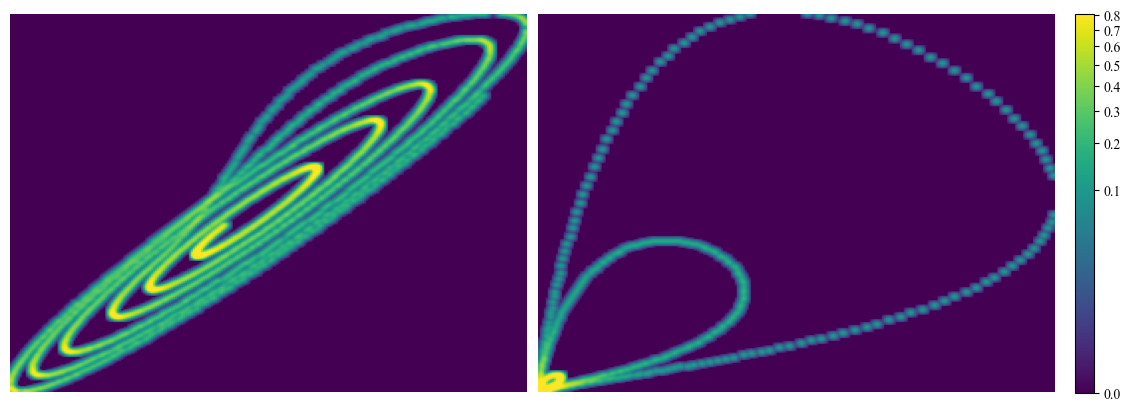

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

def _gaussian_smooth2d(A, sigma=1.2, radius=4):
    A = A.astype(np.float64, copy=False)
    k = np.arange(-radius, radius + 1, dtype=np.float64)
    g = np.exp(-(k**2) / (2 * sigma**2))
    g /= g.sum()
    B = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=0, arr=A)
    C = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=1, arr=B)
    return C

def _hist2d_log(D, bins=260, q=0.999, smooth_sigma=1.2):
    D = np.asarray(D, dtype=np.float64)
    x = D[:, 0]
    y = D[:, 1]
    x0, x1 = np.quantile(x, [1 - q, q])
    y0, y1 = np.quantile(y, [1 - q, q])
    H, xe, ye = np.histogram2d(x, y, bins=bins, range=[[x0, x1], [y0, y1]], density=False)
    if smooth_sigma is not None and smooth_sigma > 0:
        H = _gaussian_smooth2d(H, sigma=smooth_sigma, radius=max(2, int(3 * smooth_sigma)))
    Z = np.log1p(H)
    return Z.T, xe, ye

def plot_delay_invariant_heatmaps(Dx, Dz, tau, bins=260, q=0.999, smooth_sigma=1.2, gamma=0.30,
                                  cmap_name="cividis", out_pdf=None):
    Zx, xxe, xye = _hist2d_log(Dx, bins=bins, q=q, smooth_sigma=smooth_sigma)
    Zz, zxe, zye = _hist2d_log(Dz, bins=bins, q=q, smooth_sigma=smooth_sigma)

    Z_all = np.concatenate([Zx.ravel(), Zz.ravel()])
    vmax = np.percentile(Z_all, 99.8)
    vmin = 0.0
    norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)

    cmap = plt.get_cmap(cmap_name).copy()
    cmap.set_under("white")

    fig, axes = plt.subplots(1, 2, figsize=(11.2, 4.0), constrained_layout=True)
    for ax in axes:
        ax.tick_params(top=False, right=False)
        ax.set_axis_off()

    im1 = axes[0].imshow(
        Zx, origin="lower",
        extent=[xxe[0], xxe[-1], xye[0], xye[-1]],
        aspect="auto", cmap=cmap, norm=norm
    )

    im2 = axes[1].imshow(
        Zz, origin="lower",
        extent=[zxe[0], zxe[-1], zye[0], zye[-1]],
        aspect="auto", cmap=cmap, norm=norm
    )
    cbar = fig.colorbar(im2, ax=axes.ravel().tolist(), fraction=0.035, pad=0.02)

    if out_pdf is not None:
        fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
    plt.show()

plot_delay_invariant_heatmaps(Dx_tr, Dz_tr, tau=30, cmap_name="viridis", gamma=0.30)

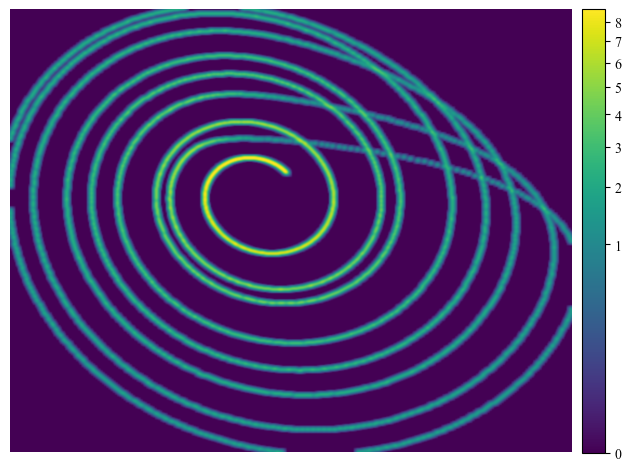

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

def _gaussian_smooth2d(A, sigma=1.4, radius=5):
    A = A.astype(np.float64, copy=False)
    k = np.arange(-radius, radius + 1, dtype=np.float64)
    g = np.exp(-(k**2) / (2 * sigma**2))
    g /= g.sum()
    B = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=0, arr=A)
    C = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=1, arr=B)
    return C

def plot_invariant_measure_xy(Y3, bins=520, q=0.995, sigma=1.6, gamma=0.35,
                                     cmap="viridis", interpolation="bicubic"):
    x = np.asarray(Y3[:, 0], dtype=np.float64)
    y = np.asarray(Y3[:, 1], dtype=np.float64)

    x0, x1 = np.quantile(x, [1-q, q])
    y0, y1 = np.quantile(y, [1-q, q])

    H, xe, ye = np.histogram2d(x, y, bins=bins, range=[[x0, x1], [y0, y1]], density=True)
    H = _gaussian_smooth2d(H, sigma=sigma, radius=max(3, int(3*sigma)))
    H = H.T

    vmax = np.percentile(H[H > 0], 99.8) if np.any(H > 0) else H.max()
    norm = PowerNorm(gamma=gamma, vmin=0.0, vmax=vmax)

    fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.6), constrained_layout=True)
    im = ax.imshow(
        H, origin="lower",
        extent=[xe[0], xe[-1], ye[0], ye[-1]],
        aspect="auto",
        cmap=cmap,
        norm=norm,
        interpolation=interpolation
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.tick_params(top=False, right=False)
    ax.set_axis_off()

    cbar = fig.colorbar(im, ax=ax, fraction=0.045, pad=0.02)

    plt.show()

plot_invariant_measure_xy(Y_scaled, bins=520, q=0.995, sigma=1.6, gamma=0.35)

# Plot Pushforward Invariant measure 

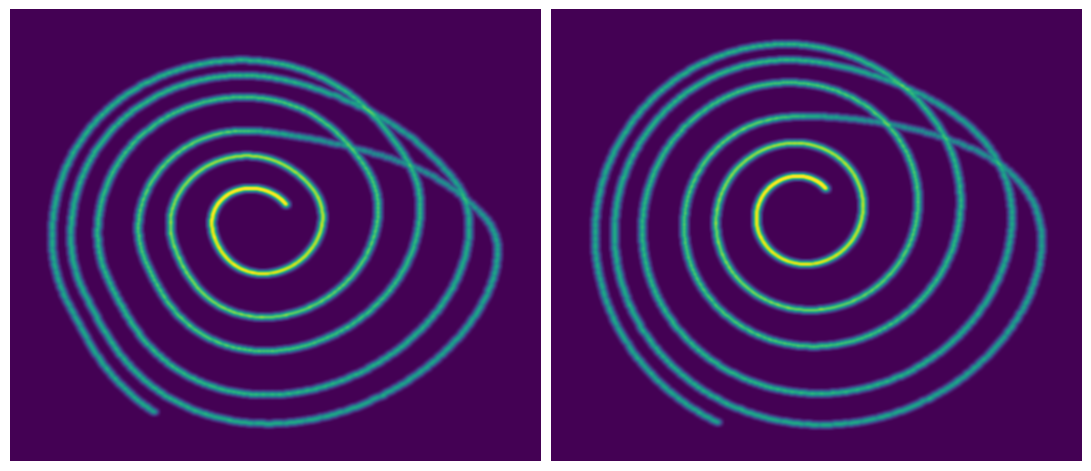

In [39]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

def rossler_rhs(xyz, a=0.2, b=0.2, c=5.7):
    x, y, z = xyz
    return np.array([-y - z, x + a * y, b + z * (x - c)], dtype=np.float64)

def simulate_rossler_euler(dt=0.01, num_steps=5000, y0=(1.0, 1.0, 0.0)):
    Y = np.zeros((num_steps + 1, 3), dtype=np.float64)
    Y[0] = np.array(y0, dtype=np.float64)
    for i in range(num_steps):
        Y[i + 1] = Y[i] + dt * rossler_rhs(Y[i])
    return Y

def build_net():
    return nn.Sequential(
        nn.Linear(3, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 3),
    )

def load_dim_model(pt_path):
    ckpt = torch.load(pt_path, map_location="cpu", weights_only=False)
    net = build_net()
    net.load_state_dict(ckpt["state_dict"])
    net.eval()
    return net, ckpt["transformer"], ckpt["config"]

@torch.no_grad()
def pushforward_points(net, Y_scaled_points, dt, p=20, chunk=20000):
    Yp = np.empty_like(Y_scaled_points, dtype=np.float32)
    N = Y_scaled_points.shape[0]
    for s in range(0, N, chunk):
        e = min(N, s + chunk)
        y = torch.tensor(Y_scaled_points[s:e], dtype=torch.float32)
        for _ in range(p):
            y = y + dt * net(y)
        Yp[s:e] = y.cpu().numpy()
    return Yp

def make_training_points(transformer, cfg, y0=(1.0, 1.0, 0.0)):
    dt = float(cfg["dt"])
    num_steps = int(cfg["num_steps"])
    tau = int(cfg["tau"])
    dim_delay = int(cfg["dim_delay"])
    split_ratio = float(cfg["split_ratio"])

    Y = simulate_rossler_euler(dt=dt, num_steps=num_steps, y0=y0)
    Y_scaled_full = transformer.transform(Y)

    Y_scaled = Y_scaled_full[:-(dim_delay - 1) * tau]
    Y_scaled = Y_scaled[:-tau]

    split = int(split_ratio * len(Y_scaled))
    return Y_scaled[:split]

def _gaussian_smooth2d(A, sigma=1.6, radius=6):
    A = A.astype(np.float64, copy=False)
    k = np.arange(-radius, radius + 1, dtype=np.float64)
    g = np.exp(-(k**2) / (2 * sigma**2))
    g /= g.sum()
    B = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=0, arr=A)
    C = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=1, arr=B)
    return C

def plot_two_measures_xy(Axy, Bxy, bins=520, q=0.995, sigma=1.6, gamma=0.35,
                         cmap="viridis", interpolation="bicubic",
                         out_png=None, out_pdf=None):
    Axy = np.asarray(Axy, dtype=np.float64)
    Bxy = np.asarray(Bxy, dtype=np.float64)

    x_all = np.concatenate([Axy[:, 0], Bxy[:, 0]])
    y_all = np.concatenate([Axy[:, 1], Bxy[:, 1]])

    x0, x1 = np.quantile(x_all, [1 - q, q])
    y0, y1 = np.quantile(y_all, [1 - q, q])

    mx = 0.1 * (x1 - x0)
    my = 0.1 * (y1 - y0)
    x0, x1 = x0 - mx, x1 + mx
    y0, y1 = y0 - my, y1 + my

    H1, xe, ye = np.histogram2d(Axy[:, 0], Axy[:, 1], bins=bins, range=[[x0, x1], [y0, y1]], density=True)
    H2, _, _ = np.histogram2d(Bxy[:, 0], Bxy[:, 1], bins=bins, range=[[x0, x1], [y0, y1]], density=True)

    H1 = _gaussian_smooth2d(H1.T, sigma=sigma, radius=max(4, int(4 * sigma)))
    H2 = _gaussian_smooth2d(H2.T, sigma=sigma, radius=max(4, int(4 * sigma)))

    H_all = np.concatenate([H1.ravel(), H2.ravel()])
    vmax = np.percentile(H_all[H_all > 0], 99.8) if np.any(H_all > 0) else H_all.max()
    norm = PowerNorm(gamma=gamma, vmin=0.0, vmax=vmax)

    fig, axes = plt.subplots(1, 2, figsize=(10.8, 4.6), constrained_layout=True)

    axes[0].imshow(
        H1,
        origin="lower",
        extent=[xe[0], xe[-1], ye[0], ye[-1]],
        aspect="auto",
        cmap=cmap,
        norm=norm,
        interpolation=interpolation
    )
    axes[0].set_axis_off()

    axes[1].imshow(
        H2,
        origin="lower",
        extent=[xe[0], xe[-1], ye[0], ye[-1]],
        aspect="auto",
        cmap=cmap,
        norm=norm,
        interpolation=interpolation
    )
    axes[1].set_axis_off()

    if out_png is not None:
        fig.savefig(out_png, dpi=300, bbox_inches="tight", pad_inches=0.1)
    if out_pdf is not None:
        fig.savefig(out_pdf, dpi=300, bbox_inches="tight", pad_inches=0.1)

    plt.show()

p = 20

net_x, transf_x, cfg_x = load_dim_model("rossler_DIM_only_x.pt")
net_z, transf_z, cfg_z = load_dim_model("rossler_DIM_only_z.pt")

Ytr_x = make_training_points(transf_x, cfg_x)
Ytr_z = make_training_points(transf_z, cfg_z)

Ytr_x_p = pushforward_points(net_x, Ytr_x, dt=float(cfg_x["dt"]), p=p)
Ytr_z_p = pushforward_points(net_z, Ytr_z, dt=float(cfg_z["dt"]), p=p)

Ytr_x_p_un = transf_x.inverse_transform(Ytr_x_p)
Ytr_z_p_un = transf_z.inverse_transform(Ytr_z_p)

Axy = Ytr_x_p_un[:, :2]
Bxy = Ytr_z_p_un[:, :2]

plot_two_measures_xy(Axy, Bxy, bins=520, q=0.995, sigma=1.6, gamma=0.35, cmap="viridis", interpolation="bicubic")


# Pushforward delay IM on NN

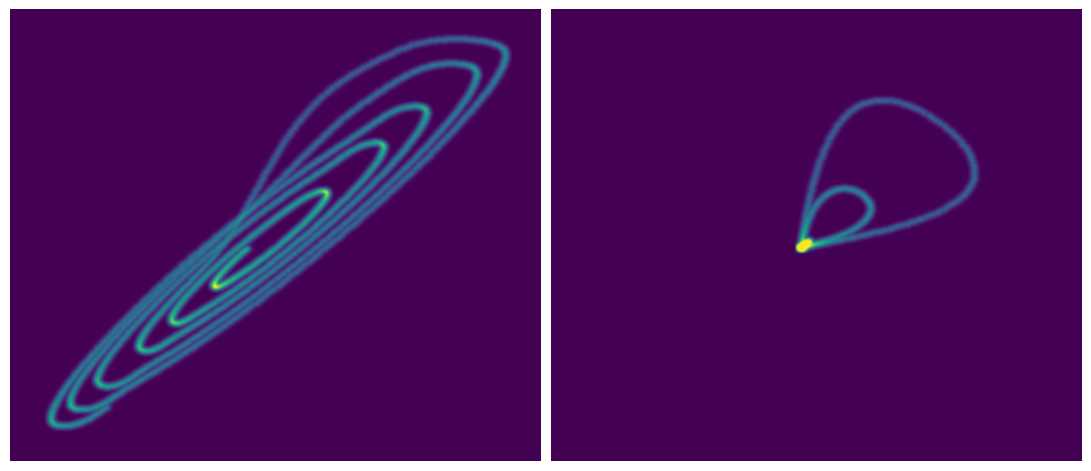

In [43]:
from matplotlib.colors import PowerNorm

def simulate_rossler_euler(dt=0.01, num_steps=5000, y0=(1.0, 1.0, 0.0)):
    y = np.zeros((num_steps + 1, 3), dtype=np.float64)
    y[0] = np.array(y0, dtype=np.float64)
    for i in range(num_steps):
        y[i + 1] = y[i] + rossler(y[i]) * dt
    return y

def build_net():
    return nn.Sequential(
        nn.Linear(3, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 3),
    )

def load_dim_model(pt_path):
    ckpt = torch.load(pt_path, map_location="cpu", weights_only=False)
    net = build_net()
    net.load_state_dict(ckpt["state_dict"])
    net.eval()
    return net, ckpt["transformer"], ckpt["config"]

@torch.no_grad()
def pushforward_points(net, Y_scaled_points, dt, p=20, chunk=20000):
    Yp = np.empty_like(Y_scaled_points, dtype=np.float32)
    N = Y_scaled_points.shape[0]
    for s in range(0, N, chunk):
        e = min(N, s + chunk)
        y = torch.tensor(Y_scaled_points[s:e], dtype=torch.float32)
        for _ in range(p):
            y = y + dt * net(y)
        Yp[s:e] = y.cpu().numpy()
    return Yp

def make_training_data_scaled(transformer, cfg, y0=(1.0, 1.0, 0.0)):
    dt = float(cfg["dt"])
    num_steps = int(cfg["num_steps"])
    tau = int(cfg["tau"])
    dim_delay = int(cfg["dim_delay"])
    split_ratio = float(cfg["split_ratio"])

    y = simulate_rossler_euler(dt=dt, num_steps=num_steps, y0=y0)
    y_scaled_full = transformer.transform(y)

    y_scaled = y_scaled_full[:-(dim_delay - 1) * tau]
    y_scaled = y_scaled[:-tau]

    split = int(split_ratio * len(y_scaled))
    y_tr = y_scaled[:split]
    return y_tr, dt, tau, dim_delay

def _gaussian_smooth2d(A, sigma=1.6, radius=6):
    A = A.astype(np.float64, copy=False)
    k = np.arange(-radius, radius + 1, dtype=np.float64)
    g = np.exp(-(k**2) / (2 * sigma**2))
    g /= g.sum()
    B = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=0, arr=A)
    C = np.apply_along_axis(lambda m: np.convolve(m, g, mode="same"), axis=1, arr=B)
    return C

def plot_two_measures_xy(Axy, Bxy, bins=520, q=0.995, sigma=1.6, gamma=0.35,
                         cmap="viridis", interpolation="bicubic",
                         pad_ratio=0.10, out_png=None, out_pdf=None):
    Axy = np.asarray(Axy, dtype=np.float64)
    Bxy = np.asarray(Bxy, dtype=np.float64)

    x_all = np.concatenate([Axy[:, 0], Bxy[:, 0]])
    y_all = np.concatenate([Axy[:, 1], Bxy[:, 1]])

    x0, x1 = np.quantile(x_all, [1 - q, q])
    y0, y1 = np.quantile(y_all, [1 - q, q])

    mx = pad_ratio * (x1 - x0)
    my = pad_ratio * (y1 - y0)
    x0, x1 = x0 - mx, x1 + mx
    y0, y1 = y0 - my, y1 + my

    H1, xe, ye = np.histogram2d(Axy[:, 0], Axy[:, 1], bins=bins, range=[[x0, x1], [y0, y1]], density=True)
    H2, _, _ = np.histogram2d(Bxy[:, 0], Bxy[:, 1], bins=bins, range=[[x0, x1], [y0, y1]], density=True)

    H1 = _gaussian_smooth2d(H1.T, sigma=sigma, radius=max(4, int(4 * sigma)))
    H2 = _gaussian_smooth2d(H2.T, sigma=sigma, radius=max(4, int(4 * sigma)))

    H_all = np.concatenate([H1.ravel(), H2.ravel()])
    vmax = np.percentile(H_all[H_all > 0], 99.8) if np.any(H_all > 0) else H_all.max()
    norm = PowerNorm(gamma=gamma, vmin=0.0, vmax=vmax)

    fig, axes = plt.subplots(1, 2, figsize=(10.8, 4.6), constrained_layout=True)

    axes[0].imshow(
        H1,
        origin="lower",
        extent=[xe[0], xe[-1], ye[0], ye[-1]],
        aspect="auto",
        cmap=cmap,
        norm=norm,
        interpolation=interpolation
    )
    axes[0].set_axis_off()

    axes[1].imshow(
        H2,
        origin="lower",
        extent=[xe[0], xe[-1], ye[0], ye[-1]],
        aspect="auto",
        cmap=cmap,
        norm=norm,
        interpolation=interpolation
    )
    axes[1].set_axis_off()

    if out_png is not None:
        fig.savefig(out_png, dpi=300, bbox_inches="tight", pad_inches=0.1)
    if out_pdf is not None:
        fig.savefig(out_pdf, dpi=300, bbox_inches="tight", pad_inches=0.1)

    plt.show()

def delay_measure_after_pushforward(net, transformer, cfg, p=20, y0=(1.0, 1.0, 0.0)):
    y_tr, dt, tau, dim_delay = make_training_data_scaled(transformer, cfg, y0=y0)
    obs_idx = int(cfg["obs_idx"])

    y_tr_p = pushforward_points(net, y_tr, dt=dt, p=p)
    obs_p = y_tr_p[:, obs_idx].astype(np.float64)

    D_p = delay_embed_scalar(obs_p, tau=tau, dim=dim_delay)
    return D_p

p = 20

net_x, transf_x, cfg_x = load_dim_model("rossler_DIM_only_x.pt")
net_z, transf_z, cfg_z = load_dim_model("rossler_DIM_only_z.pt")

Dx_p = delay_measure_after_pushforward(net_x, transf_x, cfg_x, p=p, y0=(1.0, 1.0, 0.0))
Dz_p = delay_measure_after_pushforward(net_z, transf_z, cfg_z, p=p, y0=(1.0, 1.0, 0.0))

plot_two_measures_xy(
    Dx_p[:, :2],
    Dz_p[:, :2],
    bins=520,
    q=0.995,
    sigma=1.6,
    gamma=0.35,
    cmap="viridis",
    interpolation="bicubic",
    pad_ratio=0.10
)
